# Rogun HPP - Alignment DXF to Nodes in CSV

This procedure prepares alignment data from a CAD DXF and is intended to provide necessary input to the Hydropower Waterways Decision Support System (Waterways DSS), along with the Basemaps Setup module:
- alignments for feasibilty and siting analysis
- alignments for determing geolocation of project data and for visualizing this.

[Various means of using alignemnt data for hydropower and geotechnical analysis, which includes data analysis and visualization, have been reviewed:
1. export geometry from CAD (often Civil3d) using a suitable geospatial format and use python procedures for analysis: geojson(3d) would be ideal but is hot supported; LandXML is supported from Civil3d, but we found this to be complicated and fragile; DXF export is the time-proven fallback solution 
2. perform analysis inside of CAD (probably Civil3d), most probably as plug-in developed using C++ API: not a realistic scenario in most engineering consultancy offices
3. perform analysis from CAD ((probably Civil3d) using bindings to an external software development environment (pytprobably hon): solution does not yet exist and bindings to CAD/Civil3d are considered to have a steep learning curve.

The only practical choice at this time is 1.] (move this text to Notes)

The procedure described here is one of three procedrues foreseen for preparing alignment data for the Waterways DSS:
1. select alignment geometry from CAD (or e.g. Sketchup) and export as DXF, and process with grass and python for alignment definition
2. prepare alignment with surveying software (I am using Traverse PC), using alignment data from drawings and reports
3. digitize alignments from project layouts (e.g. as prepared by Basemap Setup) together with profile data, using QGIS, and export alignment as CSV (or alternatively query coordinates at tangent points along alignment and write into a CVS data file).

This procedure adresses in particular line data exported as DXF from Sketchup:
- "alignment" polyline data (main aim)
- wire mesh line data (just as a preliminary exploration).

The exported line data can in principle be either LINE or POLYLINE. My experience however is that Sketchup exports polylines as unordered LINE data, e.g. the exported polyline segments are not in topological order. It may be possible to group or weld lines to form a polyline (plug-in?) in Sketchup, but this would need to be robust in all edge cases. It seems easier to just allow for unordered line data as input to grass and to order the line data with grass.

Wire mesh data is processed with grass to LINESTRINGS, which remain as topologically unordered line segments. As the purpose of wire mesh data is only for visulaization of structures, unordered line segments will be suitable.

"Alignment" polyline data exported from Sketchup as unordered LINE data must be processed to produce an ordered sequence of vertices along the alignment polyline. This works explores processing the "alignment" polyline data in grass.

In [1]:
# ToDo
#   all data (e.g. file names) as variables
#   markdown titles
#   comments with explanations
#   this example use grass script, do again with pygrass defining class & methods (to go into API later)


## grass setup

In [2]:
# set up Python for GRASS GIS
import os
import sys
import subprocess
from IPython.display import Image

# set up GRASS GIS runtime environment
gisbase = subprocess.check_output(["grass", "--config", "path"]).strip()
os.environ['GISBASE'] = gisbase
os.environ['GRASS_FONT'] = 'sans'
os.environ['GRASS_OVERWRITE'] = '1'  #overwrite existing maps
sys.path.append(os.path.join(gisbase, "etc", "python"))

# set display modules to render into a file (named map.png by default)
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

# import GRASS GIS
import grass.script as gs
import grass.script.setup as gsetup
from grass.script import core as grass

# for pygrass
from grass.pygrass.modules.shortcuts import raster as r, vector as v, general as g, display as d

from subprocess import PIPE

# further setup for GRASS GIS 
gs.set_raise_on_error(True)
#gs.set_capture_stderr(True)  #might be Python 2 vs 3 issue (unsure if Python 3 required for this Notebook)

False

In [3]:
# https://grasswiki.osgeo.org/wiki/GRASS_Python_Scripting_Library
# GRASS Python Scripting Library
# How to retrieve error messages from read_command():

def read2_command(*args, **kwargs):                                                 #rename to e.g. read_grass
   kwargs['stdout'] = grass.PIPE
   kwargs['stderr'] = grass.PIPE
   ps = grass.start_command(*args, **kwargs)
   return ps.communicate()

In [4]:
# create a mapset (mapset does not already exist)
# should only do once (but will report error and exit if already exists)

# dir /home/kaelin_joseph/projects/RogunHEP/grassdata  should already exist
!grass -c EPSG:3857 /home/kaelin_joseph/projects/RogunHPP/grassdata/RogunHPP -e
# should use grass scipt                                                                             ToDo JK !!    

# define all parameters separately                                                                   ToDo JK !!
#EPSG:3857  #WGS84 Pseudo Mercator

Cleaning up temporary files...
Creating new GRASS GIS location/mapset...
ERROR: Failed to create new location. The location <RogunHPP> already exists.
Exiting...


In [5]:
# open mapset
rcfile = gsetup.init(gisbase, 
         "/home/kaelin_joseph/projects/RogunHPP/grassdata",
         "RogunHPP/", "PERMANENT")

In [6]:
# check grass env
print grass.gisenv()

{'MAPSET': 'PERMANENT', 'GISDBASE': '/home/kaelin_joseph/projects/RogunHPP/grassdata', 'LOCATION_NAME': 'RogunHPP/'}


In [7]:
# check projection info
read2_command('g.proj', flags = 'jf')

('+proj=merc +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +no_defs +a=6378137 +rf=298.257223563 +towgs84=0.000,0.000,0.000 +to_meter=1\n',
 '')

In [8]:
#check mapsets
grass.mapsets()

['PERMANENT']

In [9]:
# define required input data files for project
#alignment = '/home/kaelin_joseph/projects/RogunHPP/data/in/AlignmentDG4.dxf'
alignment = '/home/kaelin_joseph/projects/RogunHPP/data/in/AlignmentDG3.dxf'
#alignment = '/home/kaelin_joseph/projects/RogunHPP/data/in/AlignmentDG2.dxf'


# define required output data files for project
alignment_vect = 'alignment_dg3'
alignment_vect_ = 'alignment_dg3_'
alignment_vect_clean = 'alignment_dg3_cleaned'
alignment_points = 'alignment_dg3_points'
alignment_points_csv = '/home/kaelin_joseph/projects/RogunHPP/data/out/AlignmentDg3points.csv'
alignment_lines_csv = '/home/kaelin_joseph/projects/RogunHPP/data/out/AlignmentDg3lines.csv'
alignment_polyline_csv = '/home/kaelin_joseph/projects/RogunHPP/data/out/AlignmentDg3polyline.csv'
alignment_csv = '/home/kaelin_joseph/projects/RogunHPP/data/out/AlignmentDg3.csv'

## import DXF data

In [10]:
# read dxf data 
# read2_command("v.in.dxf", input='/home/kaelin_joseph/projects/RogunHPP/data/testing/Aignment_DG4.dxf', 
#              output='alignment_dg4', flags='e')[0]
read2_command("v.in.dxf", input=alignment, 
             output=alignment_vect, flags='e')[0]

# output in 'RogunHPP/PERMANENT/vector/topography2m_r5_reduced'

#read2_command("v.in.dxf")
# pattern for 'printing grass output nicely
#   decode must be applied to each member of tuple
#   [0] -> stdout
#   [1] -> stderr
#   above are according to doc, however it seems that [1] is where all output is                  ToDo JK:  ??

''

In [11]:
# set grass region from vector data bounds
read2_command('g.region', vector=alignment_vect)

('', '')

In [12]:
# check grass region
print(g.region(flags='p',stdout_=PIPE).outputs.stdout.decode())

projection: 99 (Mercator)
zone:       0
datum:      wgs84
ellipsoid:  wgs84
north:      23325.28822309
south:      23238.0084142
west:       27528.89256936
east:       27770.44138252
nsres:      1.98363202
ewres:      1.99627118
rows:       44
cols:       121
cells:      5324



In [13]:
# report of vector data imported from dxf
#  comment out individual reporting as desired

# report imported DXF layers
print(read2_command("v.info", map=alignment_vect, layer='-1', verbose=True)[0].decode()) 

# report entities in imported DXF layers
#   adjust range as desired
out = read2_command("v.db.select", map=alignment_vect)[0].splitlines()
for line in range(0,4):
    print(out[line])

# report categories in imported DXF layers
print('\n')
print(read2_command("v.category", input=alignment_vect, layer='-1', option='report', verbose=True)[0].decode()) 

# report coordinatesin imported DXF layers
#   adjust range as desired
out = read2_command("v.report", map=alignment_vect, layer='-1', option='coor', verbose=True)[0].splitlines()
for line in range(0,1):
    print(out[line])
    
# report on attributes stored in grass sqlite database
print('\n')
print(read2_command("v.db.connect", map=alignment_vect, flags='c', verbose=True)[0].decode()) 

 +----------------------------------------------------------------------------+
 | Name:            alignment_dg3                                             |
 | Mapset:          PERMANENT                                                 |
 | Location:        RogunHPP/                                                 |
 | Database:        /home/kaelin_joseph/projects/RogunHPP/grassdata           |
 | Title:           alignment_dg3                                             |
 | Map scale:       1:2400                                                    |
 | Name of creator: kaelin_joseph                                             |
 | Organization:    GRASS Development Team                                    |
 | Source date:                                                               |
 | Timestamp (first layer): none                                              |
 |----------------------------------------------------------------------------|
 | Map format:      native              

In [14]:
# view and check imported topography
!rm map.png                                                                                 #ToDo JK: pythonize
read2_command("d.vect", map=alignment_vect, color='green')

('', 'd.vect complete.\n')

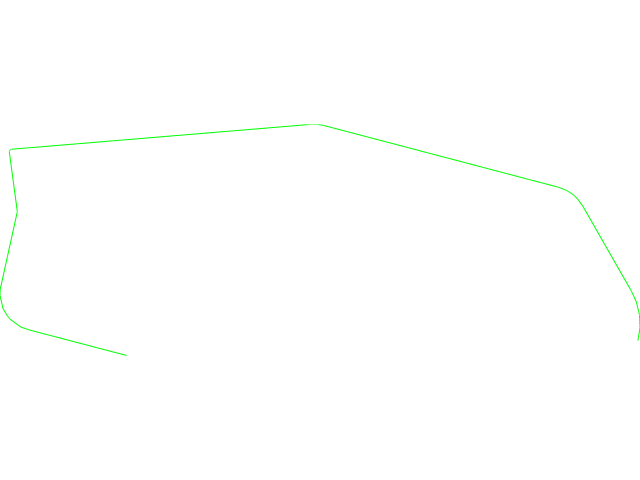

In [15]:
Image(filename="map.png")

## extract points (unordered) from imported DXF vector data

In [16]:
points_out = read2_command("v.to.points", input=alignment_vect, output=alignment_points) 
print(points_out[1].decode())

         overwritten
   2%   5%   8%  11%  14%  17%  20%  23%  26%  29%  32%  35%  38%  41%  44%  47%  50%  53%  56%  59%  62%  65%  68%  71%  74%  77%  80%  83%  86%  89%  92%  95%  98% 100%
Building topology for vector map <alignment_dg3_points@PERMANENT>...
Registering primitives...
246 primitives registered
246 vertices registered
Building areas...
   0%   2%   4%   6%   8%  10%  12%  14%  16%  18%  20%  22%  24%  26%  28%  30%  32%  34%  36%  38%  40%  42%  44%  46%  48%  50%  52%  54%  56%  58%  60%  62%  64%  66%  68%  70%  72%  74%  76%  78%  80%  82%  84%  86%  88%  90%  92%  94%

In [17]:
# view and check points topography
read2_command("d.vect", map=alignment_points, color='red')

('', 'd.vect complete.\n')

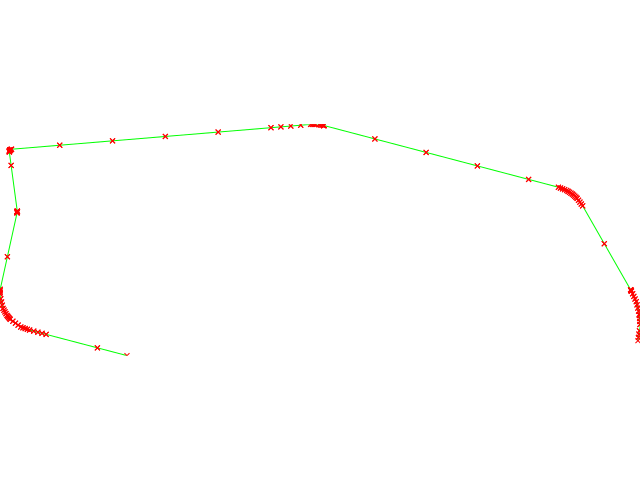

In [18]:
Image(filename="map.png")

In [19]:
#!v.out.ascii  --help

In [20]:
# write points extracted from imported DXF data to csv file

read2_command("v.out.ascii", input=alignment_points, type='point', separator=',',
              layer=-1, output=alignment_points_csv)

('', '')

In [21]:
#!head -5 /home/kaelin_joseph/projects/RogunHPP/data/out/AlignmentDg4points.csv
from __future__ import print_function
file = alignment_points_csv
with open(file, 'r') as f:
#   for line in f:
    for n in range(5):
        line = f.readline()
        print(line, end='')

27769.86054784,23244.8966299,1024.69949051
27769.66693628,23243.66812643,1024.72669945
27770.44138252,23248.58214029,1024.6178637
27770.24777096,23247.35363683,1024.64507264
27770.39771759,23249.74852115,1024.59233283


## extract lines (unordered) from imported DXF vector data

In [22]:
# write lines from imported DXF data to csv file
read2_command("v.out.ascii", input=alignment_vect, type='line', format='wkt', 
              layer=-1, output=alignment_lines_csv)

('', '')

In [23]:
# open file and read some lines
file = alignment_lines_csv
with open(file, 'r') as f:
#   for line in f:
    for n in range(5):
        line = f.readline()
        print(line, end='')

LINESTRING(27769.86054784 23244.89662990 1024.69949051, 27769.66693628 23243.66812643 1024.72669945)
LINESTRING(27770.44138252 23248.58214029 1024.61786370, 27770.24777096 23247.35363683 1024.64507264)
LINESTRING(27770.39771759 23249.74852115 1024.59233283, 27770.44138252 23248.58214029 1024.61786370)
LINESTRING(27770.24777096 23247.35363683 1024.64507264, 27770.05415940 23246.12513336 1024.67228157)
LINESTRING(27770.05415940 23246.12513336 1024.67228157, 27769.86054784 23244.89662990 1024.69949051)


In [24]:
# open csv file and read
import csv
file = alignment_lines_csv
with open(file, 'r') as f:
  reader = csv.reader(f)  
  for line in reader:
    print(line)

['LINESTRING(27769.86054784 23244.89662990 1024.69949051', ' 27769.66693628 23243.66812643 1024.72669945)']
['LINESTRING(27770.44138252 23248.58214029 1024.61786370', ' 27770.24777096 23247.35363683 1024.64507264)']
['LINESTRING(27770.39771759 23249.74852115 1024.59233283', ' 27770.44138252 23248.58214029 1024.61786370)']
['LINESTRING(27770.24777096 23247.35363683 1024.64507264', ' 27770.05415940 23246.12513336 1024.67228157)']
['LINESTRING(27770.05415940 23246.12513336 1024.67228157', ' 27769.86054784 23244.89662990 1024.69949051)']
['LINESTRING(27770.31038773 23252.08128288 1024.54127109', ' 27770.35405266 23250.91490202 1024.56680196)']
['LINESTRING(27770.35405266 23250.91490202 1024.56680196', ' 27770.39771759 23249.74852115 1024.59233283)']
['LINESTRING(27770.26672279 23253.24766374 1024.51574021', ' 27770.31038773 23252.08128288 1024.54127109)']
['LINESTRING(27770.25620226 23253.32376834 1024.51406215', ' 27770.26672279 23253.24766374 1024.51574021)']
['LINESTRING(27770.24568173 

In [25]:
# parse and format csv data to format required for plotly 3d
#https://stackoverflow.com/questions/13597088/pythonic-way-to-read-file-line-by-line#https://stackoverflow.com/questions/16731461/parsing-a-wkt-file
#https://stackoverflow.com/questions/13597088/pythonic-way-to-read-file-line-by-lin#e

import pandas as pd

file = alignment_lines_csv
test=[]

with open(file, 'r') as f:
  for line in f:
    print(line)
    l1 = line.strip('LINESTRING')
    l2 = l1.strip('\n')
    l3 = l2.strip('(')
    l4 = l3.strip(')')
    l5 = l4.split(', ')
    for item in l5:
        coords = item.split(' ')
        li = []
        for c in coords:
            li.append(float(c))
        print(li) 
        test.append(li)


LINESTRING(27769.86054784 23244.89662990 1024.69949051, 27769.66693628 23243.66812643 1024.72669945)

[27769.86054784, 23244.8966299, 1024.69949051]
[27769.66693628, 23243.66812643, 1024.72669945]
LINESTRING(27770.44138252 23248.58214029 1024.61786370, 27770.24777096 23247.35363683 1024.64507264)

[27770.44138252, 23248.58214029, 1024.6178637]
[27770.24777096, 23247.35363683, 1024.64507264]
LINESTRING(27770.39771759 23249.74852115 1024.59233283, 27770.44138252 23248.58214029 1024.61786370)

[27770.39771759, 23249.74852115, 1024.59233283]
[27770.44138252, 23248.58214029, 1024.6178637]
LINESTRING(27770.24777096 23247.35363683 1024.64507264, 27770.05415940 23246.12513336 1024.67228157)

[27770.24777096, 23247.35363683, 1024.64507264]
[27770.0541594, 23246.12513336, 1024.67228157]
LINESTRING(27770.05415940 23246.12513336 1024.67228157, 27769.86054784 23244.89662990 1024.69949051)

[27770.0541594, 23246.12513336, 1024.67228157]
[27769.86054784, 23244.8966299, 1024.69949051]
LINESTRING(27770

In [26]:
test

[[27769.86054784, 23244.8966299, 1024.69949051],
 [27769.66693628, 23243.66812643, 1024.72669945],
 [27770.44138252, 23248.58214029, 1024.6178637],
 [27770.24777096, 23247.35363683, 1024.64507264],
 [27770.39771759, 23249.74852115, 1024.59233283],
 [27770.44138252, 23248.58214029, 1024.6178637],
 [27770.24777096, 23247.35363683, 1024.64507264],
 [27770.0541594, 23246.12513336, 1024.67228157],
 [27770.0541594, 23246.12513336, 1024.67228157],
 [27769.86054784, 23244.8966299, 1024.69949051],
 [27770.31038773, 23252.08128288, 1024.54127109],
 [27770.35405266, 23250.91490202, 1024.56680196],
 [27770.35405266, 23250.91490202, 1024.56680196],
 [27770.39771759, 23249.74852115, 1024.59233283],
 [27770.26672279, 23253.24766374, 1024.51574021],
 [27770.31038773, 23252.08128288, 1024.54127109],
 [27770.25620226, 23253.32376834, 1024.51406215],
 [27770.26672279, 23253.24766374, 1024.51574021],
 [27770.24568173, 23253.39987295, 1024.51238409],
 [27770.25620226, 23253.32376834, 1024.51406215],
 [2777

In [27]:
# http://pbpython.com/pandas-list-dict.html
test_df = pd.DataFrame.from_records(test, columns=['Easting','Northing','Elevation'])
test_df.head(5)

,Easting,Northing,Elevation
0,27769.860548,23244.896630,1024.699491
1,27769.666936,23243.668126,1024.726699
2,27770.441383,23248.582140,1024.617864
3,27770.247771,23247.353637,1024.645073
4,27770.397718,23249.748521,1024.592333


## order lines segments from imported DXF vector data

In [28]:
#try v.build.polylines to order lines in a way that connects like vertices 
#  e.g. a continuous polyline from unordered line segments

read2_command("v.build.polylines", input=alignment_vect, 
             output=alignment_vect_)[0]

''

In [29]:
# report of vector data output from v.build.polyline
#  comment out individual reporting as desired

# report imported DXF layers
print(read2_command("v.info", map=alignment_vect_, layer='-1', verbose=True)[0].decode()) 

# report entities in imported DXF layers
#   adjust range as desired
out = read2_command("v.db.select", map=alignment_vect_)[0].splitlines()
print(out)

# report categories in imported DXF layers
print('\n')
print(read2_command("v.category", input=alignment_vect_, layer='-1', option='report', verbose=True)[0].decode()) 

# report coordinatesin imported DXF layers
#   adjust range as desired
out = read2_command("v.report", map=alignment_vect_, layer='-1', option='coor', verbose=True)[0].splitlines()
print(out)
    
# report on attributes stored in grass sqlite database
print('\n')
print(read2_command("v.db.connect", map=alignment_vect_, flags='c', verbose=True)[0].decode()) 

 +----------------------------------------------------------------------------+
 | Name:            alignment_dg3_                                            |
 | Mapset:          PERMANENT                                                 |
 | Location:        RogunHPP/                                                 |
 | Database:        /home/kaelin_joseph/projects/RogunHPP/grassdata           |
 | Title:           alignment_dg3                                             |
 | Map scale:       1:2400                                                    |
 | Name of creator: kaelin_joseph                                             |
 | Organization:    GRASS Development Team                                    |
 | Source date:                                                               |
 | Timestamp (first layer): none                                              |
 |----------------------------------------------------------------------------|
 | Map format:      native              

In [30]:
# view and check topography from v.build.polylines
!rm map.png                                                                                 #ToDo JK: pythonize
read2_command("d.vect", map=alignment_vect_, color='green')

('', 'd.vect complete.\n')

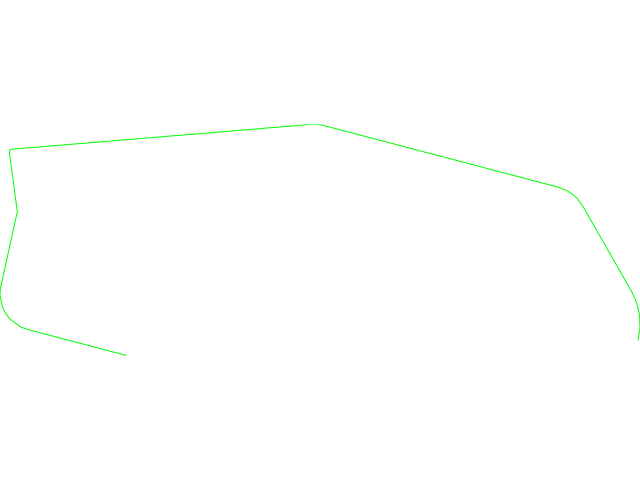

In [31]:
Image(filename="map.png")

In [32]:
# write polyline from v.build.polylines to csv file
read2_command("v.out.ascii", input=alignment_vect_, type='line', format='wkt', 
              layer=-1, output=alignment_polyline_csv)

('', '')

In [33]:
file = alignment_polyline_csv
with open(file, 'r') as f:
#   for line in f:
    for n in range(5):
        line = f.readline()
        print(line, end='')

LINESTRING(27576.81818223 23238.00841420 1016.29668734, 27565.65214280 23240.94044905 1016.53422474, 27546.30792751 23246.01995048 1016.94573812, 27544.74686947 23246.42982877 1016.97892296, 27543.18581143 23246.83970706 1017.01210780, 27541.62475340 23247.24958535 1017.04529264, 27540.06369536 23247.65946364 1017.07847748, 27539.23126482 23247.94329309 1017.09673181, 27538.39883428 23248.22712254 1017.11498615, 27537.56640373 23248.51095199 1017.13324048, 27536.73397319 23248.79478144 1017.15149481, 27535.73662988 23249.52474575 1017.17721440, 27534.73928657 23250.25471006 1017.20293399, 27533.74194326 23250.98467437 1017.22865357, 27532.74459995 23251.71463868 1017.25437316, 27532.43886169 23252.08261099 1017.26428445, 27532.13312343 23252.45058330 1017.27419573, 27531.82738517 23252.81855561 1017.28410702, 27531.52164691 23253.18652792 1017.29401831, 27531.14564372 23253.84946306 1017.30982661, 27530.76964052 23254.51239819 1017.32563491, 27530.39363733 23255.17533333 1017.34144321,

In [34]:
# parse and format csv data to format required for plotly 3d
#https://stackoverflow.com/questions/13597088/pythonic-way-to-read-file-line-by-line#https://stackoverflow.com/questions/16731461/parsing-a-wkt-file
#https://stackoverflow.com/questions/13597088/pythonic-way-to-read-file-line-by-lin#e

# comment in/out LINESTRING/LINEARRING based on polyline entity

import pandas as pd

test=[]

with open(file, 'r') as f:
  for line in f:
    #print(line)
    l1 = line.strip('LINESTRING')
    #l1 = line.strip('LINEARRING')
    l2 = l1.strip('\n')
    l3 = l2.strip('(')
    l4 = l3.strip(')')
    l5 = l4.split(', ')
    for item in l5:
        coords = item.split(' ')
        li = []
        for c in coords:
            li.append(float(c))
        print(li) 
        test.append(li)

[27576.81818223, 23238.0084142, 1016.29668734]
[27565.6521428, 23240.94044905, 1016.53422474]
[27546.30792751, 23246.01995048, 1016.94573812]
[27544.74686947, 23246.42982877, 1016.97892296]
[27543.18581143, 23246.83970706, 1017.0121078]
[27541.6247534, 23247.24958535, 1017.04529264]
[27540.06369536, 23247.65946364, 1017.07847748]
[27539.23126482, 23247.94329309, 1017.09673181]
[27538.39883428, 23248.22712254, 1017.11498615]
[27537.56640373, 23248.51095199, 1017.13324048]
[27536.73397319, 23248.79478144, 1017.15149481]
[27535.73662988, 23249.52474575, 1017.1772144]
[27534.73928657, 23250.25471006, 1017.20293399]
[27533.74194326, 23250.98467437, 1017.22865357]
[27532.74459995, 23251.71463868, 1017.25437316]
[27532.43886169, 23252.08261099, 1017.26428445]
[27532.13312343, 23252.4505833, 1017.27419573]
[27531.82738517, 23252.81855561, 1017.28410702]
[27531.52164691, 23253.18652792, 1017.29401831]
[27531.14564372, 23253.84946306, 1017.30982661]
[27530.76964052, 23254.51239819, 1017.32563491

In [35]:
# http://pbpython.com/pandas-list-dict.html
test_df = pd.DataFrame.from_records(test, columns=['Easting','Northing','Elevation'])
#test_df.head(5)
test_df

,Easting,Northing,Elevation
0,27576.818182,23238.008414,1016.296687
1,27565.652143,23240.940449,1016.534225
2,27546.307928,23246.019950,1016.945738
3,27544.746869,23246.429829,1016.978923
4,27543.185811,23246.839707,1017.012108
5,27541.624753,23247.249585,1017.045293
6,27540.063695,23247.659464,1017.078477
7,27539.231265,23247.943293,1017.096732
8,27538.398834,23248.227123,1017.114986
9,27537.566404,23248.510952,1017.133240


In [36]:
test_df.to_csv(alignment_csv)


In [37]:
file = alignment_csv
with open(file, 'r') as f:
#   for line in f:
    for n in range(5):
        line = f.readline()
        print(line, end='')

,Easting,Northing,Elevation
0,27576.81818223,23238.0084142,1016.29668734
1,27565.6521428,23240.94044905,1016.53422474
2,27546.30792751,23246.01995048,1016.94573812
3,27544.74686947,23246.42982877,1016.97892296


## additional cleaning and simplification of line segments

In [38]:
# cleaning of imported vector data required if required
#  does not seem to rm unneeded points (e.g. intermediate points along straight segments)

# https://grass.osgeo.org/grass74/manuals/v.clean.html
# https://grasswiki.osgeo.org/wiki/Vector_topology_cleaning

print(read2_command("v.clean", input=alignment_vect, 
                    tool='prune,break,snap,rmdangle,rmdupl,rmbridge,chbridge,bpol', threshold=0.001, 
                    output=alignment_vect_clean)[1].decode()) 

--------------------------------------------------
Tool: Threshold
Prune: 0.001
Break: 0
Snap vertices: 0
Remove dangles: 0
Remove duplicates: 0
Remove bridges: 0
Change type of boundary bridges: 0
Break polygons: 0
--------------------------------------------------
         overwritten
Copying features...
   2%   5%   8%  11%  14%  17%  20%  23%  26%  29%  32%  35%  38%  41%  44%  47%  50%  53%  56%  59%  62%  65%  68%  71%  74%  77%  80%  83%  86%  89%  92%  95%  98% 100%
Rebuilding parts of topology...
Building topology for vector map <alignment_dg3_cleaned@PERMANENT>...
Registering primitives...
123 primitives registered
246 vertices registered
Building areas...
   0%   2%   4%   6%   8%  10%  12%  14%  16%  18%  20%  22%  24%  26%  28%  30%

In [39]:
# v.build.polylines to order lines in a way that connects like vertices 
#  e.g. a continuous polyline from unordered line segments

read2_command("v.build.polylines", input=alignment_vect_clean, 
             output=alignment_vect_)[0]

''

In [40]:
# cleaning of polyline if required
# simplify lines (rm unneeded points, e.g. intermediate points along straight segments)
# https://grasswiki.osgeo.org/wiki/V.generalize_tutorial#Smoothing
# https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm
# https://grass.osgeo.org/grass74/manuals/v.generalize.html

print(read2_command("v.generalize", input=alignment_vect_, 
                    method='douglas_reduction', threshold=0.001, 
                    output=alignment_vect_clean)[1].decode()) 

         overwritten
Copying features...
 100%
Building topology for vector map <alignment_dg3_cleaned@PERMANENT>...
Registering primitives...
One primitive registered
124 vertices registered
Building areas...
   0% 100%
0 areas built
0 isles built
Attaching islands...
Attaching centroids...
 100%
Number of nodes: 2
Number of primitives: 1
Number of points: 0
Number of lines: 1
Number of boundaries: 0
Number of centroids: 0
Number of areas: 0
Number of isles: 0
-----------------------------------------------------
Generalization (douglas_reduction)...
Using threshold: 0.001 meters
 100%
-----------------------------------------------------
Building topology for vector map <alignment_dg3_cleaned@PERMANENT>...
Registering primitives...
One primitive registered
29 vertices registered
Building areas...
   0% 100%
0 areas built
0 isles built
Attaching islands...
Attaching centroids...
 100%
Number of nodes: 2
Number of primitives: 1
Number of points: 

In [41]:
# report of vector data output from v.build.polyline
#  comment out individual reporting as desired

# report imported DXF layers
print(read2_command("v.info", map=alignment_vect_clean, layer='-1', verbose=True)[0].decode()) 

# report entities in imported DXF layers
#   adjust range as desired
out = read2_command("v.db.select", map=alignment_vect_clean)[0].splitlines()
print(out)

# report categories in imported DXF layers
print('\n')
print(read2_command("v.category", input=alignment_vect_clean, layer='-1', option='report', verbose=True)[0].decode()) 

# report coordinatesin imported DXF layers
#   adjust range as desired
out = read2_command("v.report", map=alignment_vect_clean, layer='-1', option='coor', verbose=True)[0].splitlines()
print(out)
    
# report on attributes stored in grass sqlite database
print('\n')
print(read2_command("v.db.connect", map=alignment_vect_clean, flags='c', verbose=True)[0].decode()) 

 +----------------------------------------------------------------------------+
 | Name:            alignment_dg3_cleaned                                     |
 | Mapset:          PERMANENT                                                 |
 | Location:        RogunHPP/                                                 |
 | Database:        /home/kaelin_joseph/projects/RogunHPP/grassdata           |
 | Title:           alignment_dg3                                             |
 | Map scale:       1:2400                                                    |
 | Name of creator: kaelin_joseph                                             |
 | Organization:    GRASS Development Team                                    |
 | Source date:                                                               |
 | Timestamp (first layer): none                                              |
 |----------------------------------------------------------------------------|
 | Map format:      native              

In [42]:
# view and check topography from v.build.polylines
!rm map.png                                                                                 #ToDo JK: pythonize
read2_command("d.vect", map=alignment_vect_clean, color='green')

('', 'd.vect complete.\n')

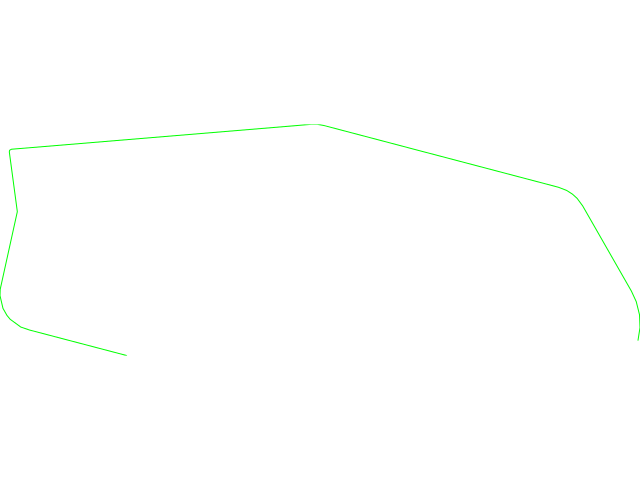

In [43]:
Image(filename="map.png")

In [44]:
# write polyline from v.build.polylines to csv file
read2_command("v.out.ascii", input=alignment_vect_clean, type='line', format='wkt', 
              layer=-1, output=alignment_polyline_csv)

('', '')

In [45]:
file = alignment_polyline_csv
with open(file, 'r') as f:
#   for line in f:
    for n in range(5):
        line = f.readline()
        print(line, end='')

LINESTRING(27576.81818223 23238.00841420 1016.29668734, 27540.06369536 23247.65946364 1017.07847748, 27536.73397319 23248.79478144 1017.15149481, 27532.74459995 23251.71463868 1017.25437316, 27531.52164691 23253.18652792 1017.29401831, 27530.01763413 23255.83826847 1017.35725150, 27528.89256936 23260.65229946 1017.46012985, 27528.96978451 23263.02759956 1017.50955914, 27535.39167911 23292.15476858 1018.12381283, 27535.41618249 23292.34303955 1018.12771856, 27535.40750025 23292.53269975 1018.13162428, 27532.41085036 23314.87481093 1018.63424754, 27532.48415631 23315.37368677 1018.64669945, 27532.60465442 23315.56968685 1018.65218888, 27533.24179010 23315.90802201 1018.66983431, 27646.13437967 23325.28106331 1021.13562185, 27648.67387649 23325.28822309 1021.19130512, 27651.04034839 23324.87935299 1021.24395564, 27739.65482103 23301.55351137 1023.23854981, 27742.76947830 23300.34592841 1023.31183478, 27744.93702562 23298.96044077 1023.36822194, 27746.71133468 23297.35439560 1023.42067052,

In [46]:
# parse and format csv data to format required for plotly 3d
#https://stackoverflow.com/questions/13597088/pythonic-way-to-read-file-line-by-line#https://stackoverflow.com/questions/16731461/parsing-a-wkt-file
#https://stackoverflow.com/questions/13597088/pythonic-way-to-read-file-line-by-lin#e

# comment in/out LINESTRING/LINEARRING based on polyline entity

import pandas as pd

test=[]

with open(file, 'r') as f:
  for line in f:
    #print(line)
    l1 = line.strip('LINESTRING')
    #l1 = line.strip('LINEARRING')
    l2 = l1.strip('\n')
    l3 = l2.strip('(')
    l4 = l3.strip(')')
    l5 = l4.split(', ')
    for item in l5:
        coords = item.split(' ')
        li = []
        for c in coords:
            li.append(float(c))
        print(li) 
        test.append(li)

[27576.81818223, 23238.0084142, 1016.29668734]
[27540.06369536, 23247.65946364, 1017.07847748]
[27536.73397319, 23248.79478144, 1017.15149481]
[27532.74459995, 23251.71463868, 1017.25437316]
[27531.52164691, 23253.18652792, 1017.29401831]
[27530.01763413, 23255.83826847, 1017.3572515]
[27528.89256936, 23260.65229946, 1017.46012985]
[27528.96978451, 23263.02759956, 1017.50955914]
[27535.39167911, 23292.15476858, 1018.12381283]
[27535.41618249, 23292.34303955, 1018.12771856]
[27535.40750025, 23292.53269975, 1018.13162428]
[27532.41085036, 23314.87481093, 1018.63424754]
[27532.48415631, 23315.37368677, 1018.64669945]
[27532.60465442, 23315.56968685, 1018.65218888]
[27533.2417901, 23315.90802201, 1018.66983431]
[27646.13437967, 23325.28106331, 1021.13562185]
[27648.67387649, 23325.28822309, 1021.19130512]
[27651.04034839, 23324.87935299, 1021.24395564]
[27739.65482103, 23301.55351137, 1023.23854981]
[27742.7694783, 23300.34592841, 1023.31183478]
[27744.93702562, 23298.96044077, 1023.368221

In [47]:
# http://pbpython.com/pandas-list-dict.html
test_df = pd.DataFrame.from_records(test, columns=['Easting','Northing','Elevation'])
#test_df.head(5)
test_df

,Easting,Northing,Elevation
0,27576.818182,23238.008414,1016.296687
1,27540.063695,23247.659464,1017.078477
2,27536.733973,23248.794781,1017.151495
3,27532.744600,23251.714639,1017.254373
4,27531.521647,23253.186528,1017.294018
5,27530.017634,23255.838268,1017.357251
6,27528.892569,23260.652299,1017.460130
7,27528.969785,23263.027600,1017.509559
8,27535.391679,23292.154769,1018.123813
9,27535.416182,23292.343040,1018.127719


In [48]:
# write alignment data to csv
test_df.to_csv(alignment_csv)

In [49]:
file = alignment_csv
with open(file, 'r') as f:
#   for line in f:
    for n in range(5):
        line = f.readline()
        print(line, end='')

,Easting,Northing,Elevation
0,27576.81818223,23238.0084142,1016.29668734
1,27540.06369536,23247.65946364,1017.07847748
2,27536.73397319,23248.79478144,1017.15149481
3,27532.74459995,23251.71463868,1017.25437316


## reverse ordered line segments

In [50]:
# aim is to be able to station in an opposite direction
# https://stackoverflow.com/questions/20444087/right-way-to-reverse-pandas-dataframe

# comment below out if the data order is not to be reversed!

# reverse order of pandas dataframe
test_df.iloc[::-1].to_csv(alignment_csv)